In [1]:
import sys
import os
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

/home/kelvin.wong/.cache/bazel/_bazel_kelvin.wong/47fc07a62b8a2107c2e1b04eb7772dd1/execroot/__main__/bazel-out/release_links/lib/python_env/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [2]:
if os.getlogin() == 'suo':
    sys.path.append('/home/suo/dev/chexpert-fusion/fusion_experiments') 
    DATASET_PATH = '/home/suo/data/CheXpert-v1.0'
    MIMIC_DATASET_PATH = '/home/suo/data/MIMIC-CXR'
elif os.getlogin() == 'kelvin.wong':
    sys.path.append('/home/kelvin.wong/Developer/chexpert-fusion/fusion_experiments')
    DATASET_PATH = '/home/kelvin.wong/Datasets/CheXpert-v1.0'
    MIMIC_DATASET_PATH = '/home/kelvin.wong/Datasets/MIMIC-CXR'

from config.chexpert import CHEXPERT_CLASSES, PAPER_TRAINING_CLASSES
from data.datasets.paired_chexpert import PairedCheXpertDataset, PairedOnlyCheXpertDataset, PairedOnlyCustomSplit 
from data.datasets.paired_mimic import PairedOnlyMIMICDataset

MODE = 'train'
CLASS_NAMES = PAPER_TRAINING_CLASSES
SET_UNOBSERVED_TO_NEGATIVE = True
BAR_WIDTH = 0.8

In [3]:
def get_label_count(studies):
    dist = {
        'positive': np.zeros(len(CLASS_NAMES)), 
        'negative': np.zeros(len(CLASS_NAMES)), 
        'uncertain': np.zeros(len(CLASS_NAMES)), 
        'total': np.zeros(len(CLASS_NAMES))
    }

    for study in studies:
        dist['positive'] += (study['labels'] == 1) * study['mask']
        dist['negative'] += (study['labels'] == 0) * study['mask']
        dist['uncertain'] += 1 - study['mask']
        dist['total'] += np.ones_like(study['labels'])
    
    return dist

def get_label_distribution(studies):
    counts = get_label_count(studies)
    dist = {key: count / counts['total'] * 100 for key, count in counts.iteritems()}
    return dist 

In [4]:
def draw_dist_bar(axe, dist):
    b1 = axe.bar(range(len(dist['negative'])), dist['negative'], width=BAR_WIDTH, label='Negative')
    b2 = axe.bar(range(len(dist['negative'])), dist['positive'], width=BAR_WIDTH, bottom=dist['negative'], label='Positive')
    b3 = axe.bar(range(len(dist['negative'])), dist['uncertain'], width=BAR_WIDTH, bottom=(dist['negative'] + dist['positive']),label='Uncertain')
    return b1, b2, b3

def draw_delta_dist_bar(axe, dist1, dist2):
    b1 = axe.bar(range(len(dist1['negative'])), dist1['negative'] - dist2['negative'], width=0.3, label='Negative')
    b2 = axe.bar([x + 0.33 for x in range(len(dist1['negative'] ))], dist1['positive'] - dist2['positive'], width=0.3, label='Positive')
    b3 = axe.bar([x + 0.66 for x in range(len(dist1['negative'] ))], dist1['uncertain'] - dist2['uncertain'], width=0.3, label='Uncertain')
    return b1, b2, b3

def plot_dist_difference(d1_dist, d2_dist, d1_name, d2_name):
    FIGURE, AXES = plt.subplots(ncols=3)
    FIGURE.set_figwidth(25)
    FIGURE.set_figheight(5)

    draw_dist_bar(AXES[0], d1_dist)
    AXES[0].set_xticks([x for x in range(len(d1_dist['negative']))])
    AXES[0].set_xticklabels(CLASS_NAMES, rotation=0, fontsize='large')
    AXES[0].set_title('{} Dataset'.format(d1_name), fontsize='xx-large')

    draw_dist_bar(AXES[1], d2_dist)
    AXES[1].set_xticks([x for x in range(len(d1_dist['negative']))])
    AXES[1].set_xticklabels(CLASS_NAMES, rotation=0, fontsize='large')
    AXES[1].set_title('{} Dataset'.format(d2_name), fontsize='xx-large')

    b_neg, b_pos, b_uncertain = draw_delta_dist_bar(AXES[2], d1_dist, d2_dist)
    AXES[2].set_xticks([x + 0.5 for x in range(len(d1_dist['negative']))])
    AXES[2].set_xticklabels(CLASS_NAMES, rotation=0, fontsize='large')
    AXES[2].set_title('% Change in Label Distribution', fontsize='xx-large')
    AXES[2].legend([b_neg, b_pos, b_uncertain], ['Negative', 'Positive', 'Uncertain'], bbox_to_anchor=(1.04, 0.5), loc='center left', fontsize='xx-large')

    plt.show()

# CheXpert vs. CheXpert Paired

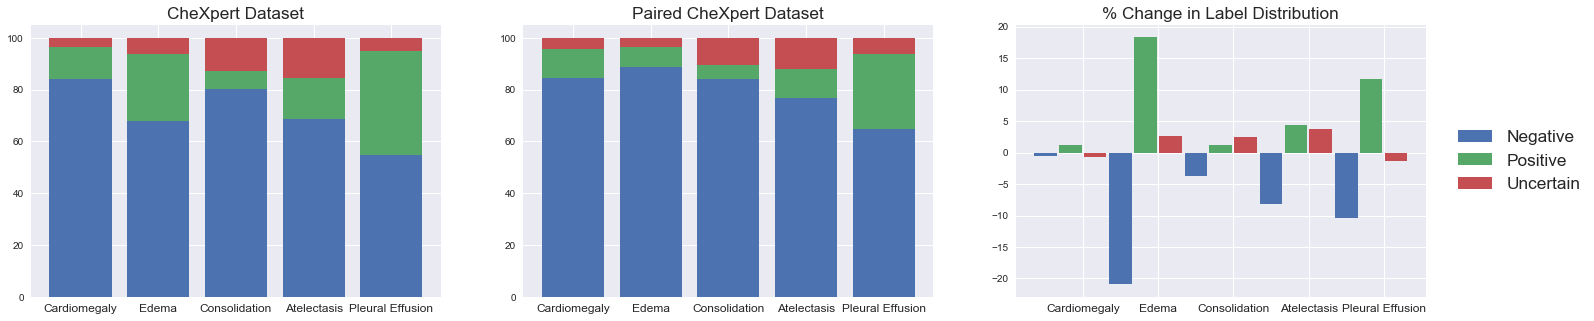

In [5]:
dataset1 = PairedCheXpertDataset(DATASET_PATH, MODE, CLASS_NAMES, None, SET_UNOBSERVED_TO_NEGATIVE)
dataset2 = PairedOnlyCheXpertDataset(DATASET_PATH, MODE, CLASS_NAMES, None, SET_UNOBSERVED_TO_NEGATIVE)

d1_dist = get_label_distribution(dataset1.studies)
d2_dist = get_label_distribution(dataset2.studies)

plot_dist_difference(d1_dist, d2_dist, 'CheXpert', 'Paired CheXpert')

# CheXpert Paired vs. MIMIC Paired

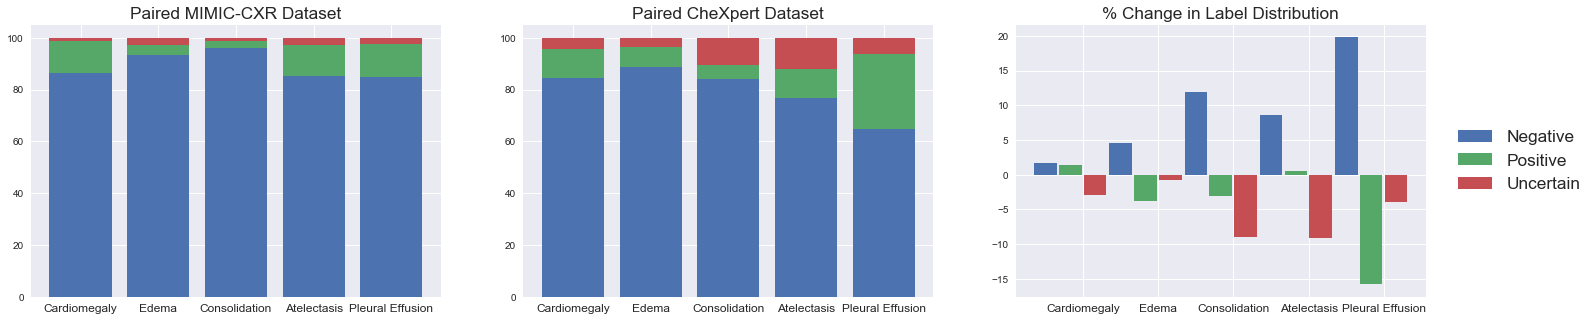

In [6]:
dataset1 = PairedOnlyMIMICDataset(MIMIC_DATASET_PATH, 'valid', CLASS_NAMES, None, SET_UNOBSERVED_TO_NEGATIVE)
dataset2 = PairedOnlyCheXpertDataset(DATASET_PATH, MODE, CLASS_NAMES, None, SET_UNOBSERVED_TO_NEGATIVE)

d1_dist = get_label_distribution(dataset1.studies)
d2_dist = get_label_distribution(dataset2.studies)

plot_dist_difference(d1_dist, d2_dist, 'Paired MIMIC-CXR', 'Paired CheXpert')